In [1]:
from PIL.ImageColor import colormap
from matplotlib.pyplot import ylabel

from config import DATA_PATH, ANALYSIS_OPS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from utils.analysis_fns import *
from utils.plotting import *

In [2]:
df = pd.read_csv(DATA_PATH)

meta_cols = ['model_name', 'model_key', 'slug', 'creator', 'release_date', 'core10_count']
honesty_cols = ['honesty_score', 'confidence_interval']

df_info = df[meta_cols]
df_honesty = df[honesty_cols]
df_bench = df.drop(columns=meta_cols + honesty_cols)

In [3]:
print(df_bench.shape)
df_bench.head()

(54, 12)


,gpqa,hle,scicode,livecodebench,mmlu_pro,aime_25,ifbench,lcr,terminalbench_hard,tau2,math_500,aime
0,0.656,0.048,0.376,0.394,0.803,0.210,0.440,0.483,0.212,0.500,0.850,0.223
1,0.772,0.103,0.403,0.473,0.837,0.563,0.483,0.607,0.212,0.547,0.947,0.487
2,0.796,0.117,0.398,0.636,0.873,0.733,0.537,0.337,0.311,0.705,0.982,0.757
3,0.683,0.040,0.373,0.449,0.837,0.380,0.454,0.443,0.273,0.523,0.934,0.407
4,0.777,0.096,0.400,0.655,0.842,0.743,0.547,0.647,0.311,0.646,0.991,0.773


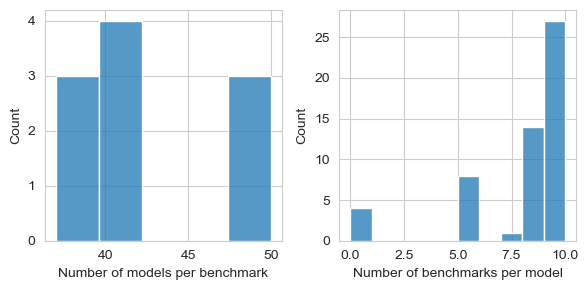

In [4]:
# data seem very sparse - first look at what we're dealing with
models_per_bench = df_bench.iloc[:, 2:].notna().sum(axis=0)  # per column
benchs_per_model = df_bench.iloc[:, 2:].notna().sum(axis=1)  # per row

fig, ax = plt.subplots(1,2,figsize=(6, 3))
sns.histplot(ax=ax[0], data=models_per_bench)
ax[0].set(xlabel='Number of models per benchmark')

sns.histplot(ax=ax[1], data=benchs_per_model)
ax[1].set(xlabel='Number of benchmarks per model')

plt.tight_layout()  

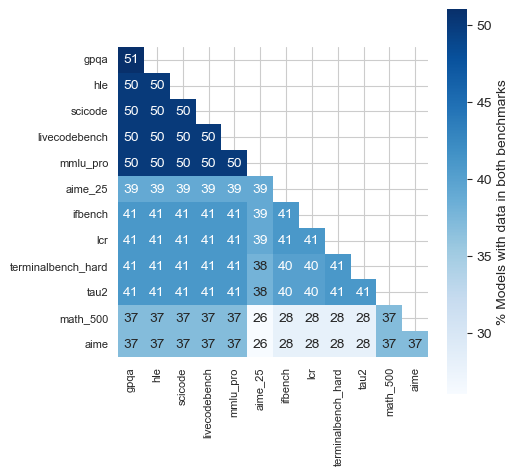

In [5]:
fig, ax = plt.subplots(figsize=(5,5))

overlap_matrix = df_bench.notna().astype(int).T @ df_bench.notna().astype(int)
sns.heatmap(ax=ax, 
            data=np.tril(overlap_matrix),
            mask=np.triu(np.ones_like(overlap_matrix, dtype=bool), k=1),
            cmap='Blues', 
            annot=True,
            cbar_kws={'label': '% Models with data in both benchmarks'},
            square=True,
            yticklabels=overlap_matrix.index,
            xticklabels=overlap_matrix.index)
ax.tick_params(axis='y', labelsize=8)  # Adjust size if needed
ax.tick_params(axis='x', labelsize=8, rotation=90)

<Axes: >

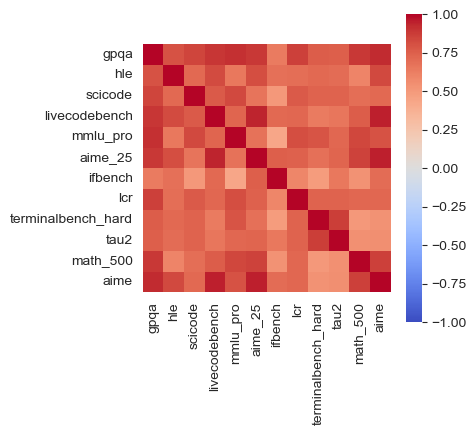

In [6]:
# plot correlation matrix
r = df_bench.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(data=r,
            vmin=-1, vmax=1,
            square=True,
            cmap='coolwarm', 
            xticklabels=df_bench.columns)

In [7]:
# kNN imputation to fill in missing
X_raw = df_bench.values
X_scaled = (X_raw - np.nanmean(X_raw, axis=0)) / np.nanstd(X_raw, axis=0)
X_full = knn_impute(X_scaled, n_neighbours=ANALYSIS_OPS['kNN_k'])

In [8]:
real_expVar, null_expVar = parallel_analysis(X_full, n_shuffles=100)

Number of components above 99% CI: 1


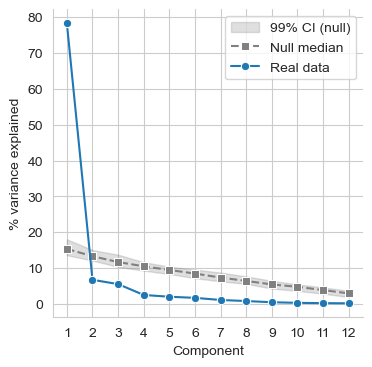

In [9]:
visualize_parallel_analysis_results(real_expVar, null_expVar, ci_size=99, convert_to_expvar=True)

In [10]:
def loadings_heatmap(weights: np.ndarray, var_names: list[str]):
    n_vars, n_comp = weights.shape
    order = np.lexsort((-np.max(np.abs(weights), axis=1), np.argmax(np.abs(weights), axis=1)))
    df = pd.DataFrame(weights[order], index=np.array(var_names)[order],
                       columns=[f"PC{i+1}" for i in range(n_comp)])

    fig, ax = plt.subplots(figsize=(max(4, n_comp), max(5, n_vars * 0.3)))
    vmax = np.abs(weights).max()
    sns.heatmap(df, center=0, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                annot=True, fmt='.2f', linewidths=0.5, ax=ax)
    ax.tick_params(axis='y', rotation=0)
    plt.tight_layout()
    return ax

<Axes: xlabel='Release date', ylabel='g'>

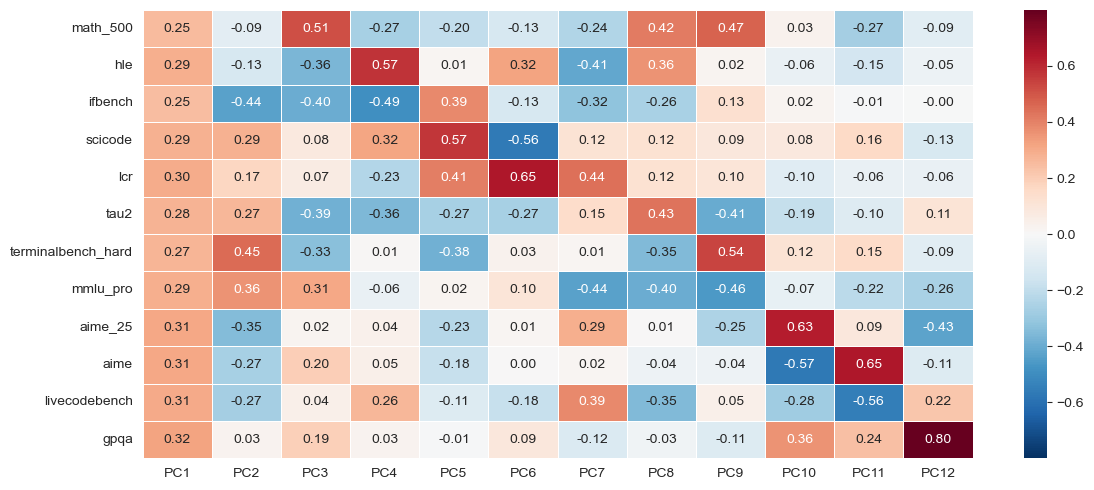

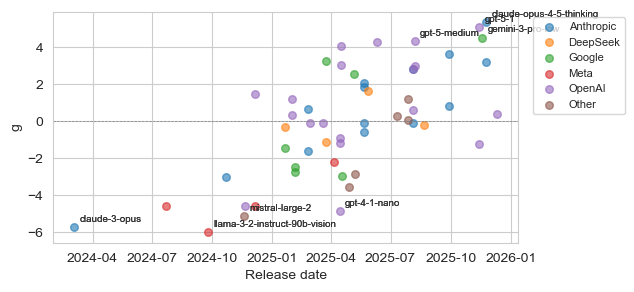

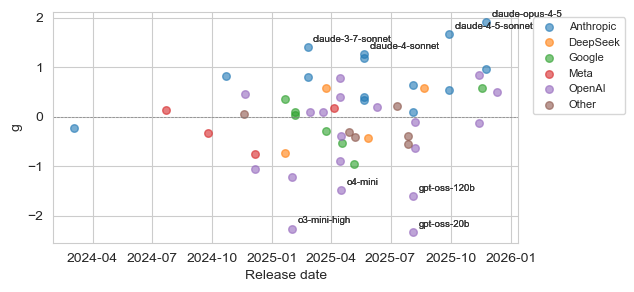

In [11]:
scores, components, exp_var = pca_scores(X_full)
loadings_heatmap(components.T, var_names=df_bench.columns)
plot_component_v_time(scores, 0, 'g', df_info, n_label=8)
plot_component_v_time(scores, 1, 'g', df_info, n_label=8)


Parallel analysis is indicating just one factor - but with such a dominant first dimension, this approac is almost certainly over-penalising PCs 2+.

Let's try a different approach to confirm.

In [12]:
real_var, null_var = pca_cv(X_full, n_splits=100, holdout_frac=0.1)

Components above 95% CI: 1


<Axes: xlabel='Component', ylabel='Held-out variance explained'>

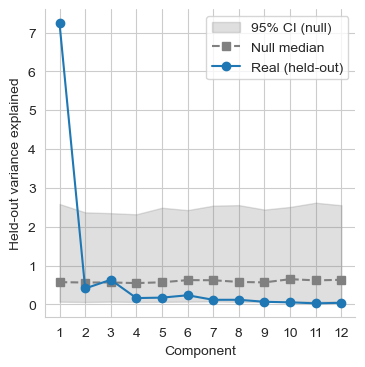

In [13]:
null_flat = null_var.transpose(0, 2, 1).reshape(-1, null_var.shape[1])
plot_cv_parallel(real_var, null_flat, ci_size=95)

In [14]:


def permutation_test_deltaR2(y, X_base, X_extra, n_perms=10000, seed=0):
    """
    Permutation test for whether additional regressors (X_extra) improves R2 beyond base model (X_base).

    Shuffles rows of X_extra to break association with y, refits, and builds a null distribution of delta R2.

    Returns: observed ΔR², null distribution, p-value, full model OLS result
    """
    rng = np.random.default_rng(seed)

    X_full = sm.add_constant(np.hstack([X_base, X_extra]))
    X_restricted = sm.add_constant(X_base)

    m_restricted = sm.OLS(y, X_restricted).fit()
    m_full = sm.OLS(y, X_full).fit()
    observed = m_full.rsquared - m_restricted.rsquared

    null = np.zeros(n_perms)
    for i in range(n_perms):
        X_extra_shuf = X_extra.copy()
        rng.shuffle(X_extra_shuf)
        X_perm = sm.add_constant(np.hstack([X_base, X_extra_shuf]))
        null[i] = sm.OLS(y, X_perm).fit().rsquared - m_restricted.rsquared

    p = np.mean(null >= observed)
    return observed, null, p, m_full

In [15]:
has_honesty = df_honesty['honesty_score'].notna()
y = df_honesty.loc[has_honesty, 'honesty_score'].values

creator = df_info.loc[has_honesty, 'creator'].copy()
top5 = creator.value_counts().head(5).index
creator = creator.where(creator.isin(top5), other='Other')
creator_dummies = pd.get_dummies(creator, drop_first=False).drop(columns='Other').astype(float).values

dates = pd.to_datetime(df_info.loc[has_honesty, 'release_date']).astype(int).values.reshape(-1, 1)
dates = (dates - dates.mean()) / dates.std()  # standardize

# step 1 baseline: creator + date
X_base = np.hstack([creator_dummies, dates])
X_base = np.hstack([creator_dummies])

# step 2: does g help?
X_extra_g = scores[has_honesty, :1]
delta_g, null_g, p_g, _= permutation_test_deltaR2(y, X_base, X_extra_g)
print(f"Base Info (creator) → +PC1:   ΔR²={delta_g:.3f}  p={p_g:.4f}")

# step 3: do PC2-3 help beyond g?
X_base_g = np.hstack([X_base, X_extra_g])
X_extra_23 = scores[has_honesty, 1:3]
delta_23, null_23, p_23, _ = permutation_test_deltaR2(y, X_base_g, X_extra_23)
print(f"Base Info +PC1 → +PC2-3:         ΔR²={delta_23:.3f}  p={p_23:.4f}")

# step 3b: do PC11-12 help beyond g?
X_base_g = np.hstack([X_base, X_extra_g])
X_extra_cntrl = scores[has_honesty, 10:13]
delta_cntrl, null_cntrl, p_cntrl, _ = permutation_test_deltaR2(y, X_base_g, X_extra_cntrl)
print(f"Base Info +PC1 → +PC10-12:         ΔR²={delta_cntrl:.3f}  p={p_cntrl:.4f}")

Base Info (creator) → +PC1:   ΔR²=0.100  p=0.0001
Base Info +PC1 → +PC2-3:         ΔR²=0.045  p=0.0134
Base Info +PC1 → +PC10-12:         ΔR²=0.013  p=0.3183


In [32]:
has_honesty = df_honesty['honesty_score'].notna()
y = df_honesty.loc[has_honesty, 'honesty_score'].values

creator = df_info.loc[has_honesty, 'creator'].copy()
top5 = creator.value_counts().head(5).index
creator = creator.where(creator.isin(top5), other='Other')
creator_dummies = pd.get_dummies(creator, drop_first=False).drop(columns='Other').astype(float).values

dates = pd.to_datetime(df_info.loc[has_honesty, 'release_date']).astype(int).values.reshape(-1, 1)
dates = (dates - dates.mean()) / dates.std()  # standardize

X_base = np.hstack([creator_dummies, dates])
n_pcs = scores.shape[1]
results = {}
for k in range(n_pcs):
    X_extra = scores[has_honesty, k:k+1]
    delta, null, p, m = permutation_test_loo(y, X_base, X_extra)
    beta = m.params[-1]
    results[k+1] = {'delta': delta, 'p': p, 'beta': beta, 'model': m}
    print("PC{}: LOO dR2={:.3f} p={:.4f} beta={:+.3f}".format(k+1, delta, p, beta), flush=True)
    X_base = np.hstack([X_base, X_extra])

PC1: LOO dR2=0.030 p=0.0190 beta=+1.625
PC2: LOO dR2=-0.002 p=0.2140 beta=-3.676
PC3: LOO dR2=0.052 p=0.0050 beta=-6.147
PC4: LOO dR2=-0.017 p=0.8970 beta=-3.134
PC5: LOO dR2=0.033 p=0.0120 beta=-7.406
PC6: LOO dR2=-0.013 p=0.8020 beta=-0.411
PC7: LOO dR2=-0.008 p=0.3910 beta=-2.254
PC8: LOO dR2=0.000 p=0.1880 beta=-5.031
PC9: LOO dR2=0.002 p=0.1460 beta=+10.302
PC10: LOO dR2=-0.010 p=0.5350 beta=+0.843
PC11: LOO dR2=-0.012 p=0.5870 beta=-5.677
PC12: LOO dR2=-0.013 p=0.4980 beta=-9.733


In [33]:
for k, r in results.items():
    if r['p'] < 0.01:
        top_loadings(components[k-1:k].T, df_bench.columns.tolist(), n_top=5, start_idx=k-1)


PC3
                                  math_500  +0.515
                                   ifbench  -0.397
                                      tau2  -0.387
                                       hle  -0.364
                        terminalbench_hard  -0.333


In [34]:

def loadings_heatmap(weights: np.ndarray, var_names: list[str], comp_labels: list[str] = None):
    n_vars, n_comp = weights.shape
    if comp_labels is None:
        comp_labels = [f"PC{i+1}" for i in range(n_comp)]
    order = np.lexsort((-np.max(np.abs(weights), axis=1), np.argmax(np.abs(weights), axis=1)))
    df = pd.DataFrame(weights[order], index=np.array(var_names)[order],
                       columns=comp_labels)

    fig, ax = plt.subplots(figsize=(max(4, n_comp), max(5, n_vars * 0.3)))
    vmax = np.abs(weights).max()
    sns.heatmap(df, center=0, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                annot=True, fmt='.2f', linewidths=0.5, ax=ax)
    ax.tick_params(axis='y', rotation=0)
    plt.tight_layout()
    return ax

<Axes: >

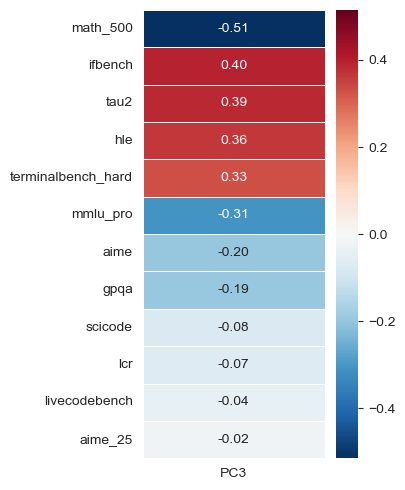

In [31]:
sig_pcs = [k for k, r in results.items() if r['p'] < 0.01]
sig_components = components[np.array(sig_pcs) - 1]  # (n_sig, n_vars)

# flip so positive loadings = predicts more honesty
signs = np.array([np.sign(results[k]['beta']) for k in sig_pcs]).reshape(-1, 1)
sig_components = sig_components * signs
loadings_heatmap(sig_components.T, df_bench.columns.tolist(),
                 comp_labels=[f"PC{k}" for k in sig_pcs])

In [82]:
honesty_direction = np.zeros(components.shape[1])
for k, r in results.items():
    if r['p'] < 0.05:
        honesty_direction += r['beta'] * components[k-1]

# normalize for readability
honesty_direction /= np.linalg.norm(honesty_direction)

df = pd.DataFrame({'benchmark': df_bench.columns, 'weight': honesty_direction})
df = df.sort_values('weight', ascending=False)
print(df.to_string(index=False))

         benchmark    weight
terminalbench_hard  0.546524
              tau2  0.491781
               hle  0.266499
           aime_25  0.212604
     livecodebench  0.108259
              aime  0.062770
           ifbench -0.000689
              gpqa -0.060064
          math_500 -0.131886
          mmlu_pro -0.164049
               lcr -0.302336
           scicode -0.433889


In [23]:
# remove PC1 from benchmarks
X_bench = X_full[has_honesty]
pc1_scores = scores[has_honesty, :1]
X_resid = X_bench - pc1_scores @ components[:1]
# remove PC1 from honesty
y_resid = sm.OLS(y, sm.add_constant(pc1_scores)).fit().resid

# regress residual honesty on residual benchmarks
m = sm.OLS(y_resid, sm.add_constant(X_resid)).fit()

df_coefs = pd.DataFrame({
    'benchmark': df_bench.columns,
    'beta': m.params[1:],
    'p': m.pvalues[1:]
}).sort_values('beta', ascending=False)
print(df_coefs.to_string(index=False))

         benchmark       beta        p
terminalbench_hard  17.997151 0.000575
           aime_25  10.011343 0.182704
           ifbench   6.683386 0.038516
           scicode   3.333567 0.391531
     livecodebench   0.884760 0.899957
          mmlu_pro  -0.249625 0.964562
              tau2  -1.200705 0.796365
          math_500  -1.606690 0.755038
               lcr  -4.430939 0.242139
              aime  -6.541724 0.419259
               hle  -9.897463 0.012521
              gpqa -11.214588 0.244031


In [25]:
X_bench = X_full[has_honesty]
pc1_scores = scores[has_honesty, :1]
X_resid = X_bench# - pc1_scores @ components[:1]

n_perms = 10000
rng = np.random.default_rng(0)

m_real = sm.OLS(y_resid, sm.add_constant(X_resid)).fit()
real_betas = m_real.params[1:]

null_betas = np.zeros((n_perms, X_resid.shape[1]))
for i in range(n_perms):
    X_shuf = X_resid.copy()
    for j in range(X_resid.shape[1]):
        rng.shuffle(X_shuf[:, j])
    null_betas[i] = sm.OLS(y_resid, sm.add_constant(X_shuf)).fit().params[1:]

p_perm = np.mean(np.abs(null_betas) >= np.abs(real_betas), axis=0)

df_coefs = pd.DataFrame({
    'benchmark': df_bench.columns,
    'beta': real_betas,
    'p_perm': p_perm
}).sort_values('beta', ascending=False)
print(df_coefs.to_string(index=False))

         benchmark       beta  p_perm
terminalbench_hard  17.930511  0.0000
           aime_25   9.934115  0.0000
           ifbench   6.621523  0.0057
           scicode   3.262853  0.1743
     livecodebench   0.808874  0.7390
          mmlu_pro  -0.321403  0.9032
              tau2  -1.270146  0.6028
          math_500  -1.669021  0.5210
               lcr  -4.504805  0.0548
              aime  -6.617699  0.0046
               hle  -9.969328  0.0000
              gpqa -11.293970  0.0000


In [35]:
bench_names = df_bench.columns.tolist()
X_full_h = X_full[has_honesty]

agentic = ['terminalbench_hard', 'tau2', 'ifbench']
reasoning = ['scicode', 'lcr', 'math_500', 'gpqa']

agentic_idx = [bench_names.index(b) for b in agentic]
reasoning_idx = [bench_names.index(b) for b in reasoning]

agentic_score = X_full_h[:, agentic_idx].mean(axis=1)
reasoning_score = X_full_h[:, reasoning_idx].mean(axis=1)
contrast = agentic_score - reasoning_score
g = scores[has_honesty, 0]

X_base = sm.add_constant(np.column_stack([creator_dummies, g]))
X_extra = contrast.reshape(-1, 1)

delta, null, p, m = permutation_test_loo(y, X_base, X_extra)
print("Agentic vs Reasoning contrast: LOO dR2={:.3f} p={:.4f} beta={:+.3f}".format(delta, p, m.params[-1]))

Agentic vs Reasoning contrast: LOO dR2=0.066 p=0.0000 beta=+10.975


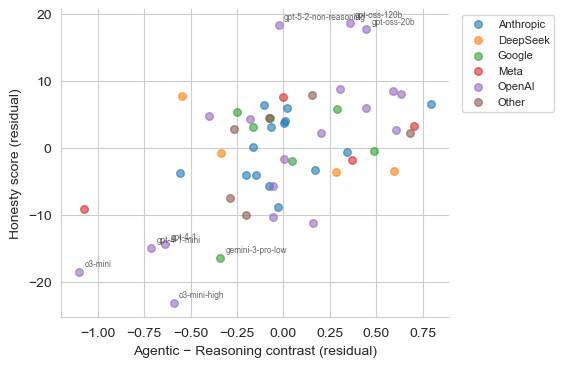

In [37]:
# residualize both honesty and contrast
X_base = sm.add_constant(np.column_stack([creator_dummies, g]))
y_resid = sm.OLS(y, X_base).fit().resid
contrast_resid = sm.OLS(contrast, X_base).fit().resid

fig, ax = plt.subplots(figsize=(5, 4))
for name, idx in creator.groupby(creator).groups.items():
    ax.scatter(contrast_resid[idx], y_resid[idx], label=name, alpha=0.6, s=30)

ax.set_xlabel('Agentic − Reasoning contrast (residual)')
ax.set_ylabel('Honesty score (residual)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
sns.despine()

for i in np.argsort(np.abs(y_resid))[-8:]:
    ax.annotate(df_info.loc[has_honesty, 'slug'].iloc[i],
                (contrast_resid[i], y_resid[i]), fontsize=6, alpha=0.7,
                xytext=(4, 4), textcoords='offset points')